# Характеристика канала между RFID считывателем и меткой
В ноутбуке представлены результаты моделирования канала для случая, когда RFID считыватель закреплён на движущимся равномерно и прямолинейно БПЛА, а метки неподвижно лежат на земеле на таком расстоянии, что между ними никогда не возникает коллизий.
В ноутбуке приведены результаты для нескольких сценариев:
1) БПЛА и метка неподвижны друг относительно друга (дрон завис в воздухе)
2) Дрон движется, метка принимает только прямой луч (дрон над полем без препятствий)
3) Дрон движется, на метку попадает прямой и отражённый лучи (дрон летит вдоль стены, от которой происходит отражение)

В коде есть одно важное логическое допущение: **в ходе симуляции изменение координат (т.е. движение) происходит только у метки**. То есть для модели RFID считыватель является неподвижным объектом, а метка - подвижным. Это связано с историей разработки модели (изначально неподвижно закреплённый на столбе считыватель идентифицировал движущиеся метки, находящиеся на автомобильных номерах) и не было изменено из-за того, что такая физческая величина как скорость является **относительной величиной**. То есть с точки зрения физики не важно, что движется - считыватель или метка. Главное, что они движутся друг относительно друга.

## Подготовка ноутбука
Импортируем все необходимые библиотеки, настроим флаги и константы, которыми будем пользоваться в эксперименте, и определим служебные функции, чтобы не отвлекаться на них в расчетной части эксперимента.

In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import patches
from typing import Sequence, Tuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from pysim.models.rfid import channel
from utility.graphs_style import (
    get_color, setup_matplotlib,
)
import pysim.models.rfid.epcstd as epc
# from pyons.models.rfid.pyradise import w2dbm, dbm2w, db2lin

In [3]:
%matplotlib inline
setup_matplotlib()

## Параметры моделирования
Для работы модели требуется определить положение метки и считывателя в трёхмерном пространстве с помощью декартовых координат.
* Симуляция проходит в трёхмерном пространстве. Это значение хранит константа `DIMENSION_OF_SPACE`. Соответственно, все координаты, вектора скорости и направления антенн определяются как трёхмерные массивы координат типа `np.array`;
* Точка `(0;0;0)` находится у основания стены (TODO: картинка);
* Ось абцисс `(OX)` направлена перпендикулярно движению БПЛА со считывателем;
* Ось ординат `(OY)` направлена параллельно движению БПЛА;
* Ось аппликат `(OZ)` направлена вдоль стены вверх;
* Стена (если есть) находится в плоскости `YOZ`;

Требования:
1) Положение считывателя и метки указывается как `np.array((x, y, z))`, где x, y, z - координаты в метрах в начале моделирования;

### Параметры окружающей среды

In [4]:
FREQUENCY = 860_000_000              # Герц
SPEED_OF_LIGHT = 299_792_458         # Метров в секунду
WAVELEN = SPEED_OF_LIGHT / FREQUENCY
THERMAL_NOISE = -114.0               # dBm
DIMENSION_OF_SPACE = 3

# Поляризация--------------------------------
VERTICAL_POLARIZATION = 0.0
HORIZONTAL_POLARIZATION = 1.0
CIRCULAR_POLARIZATION = 0.5

# Характеристики поверхности отражения-------
PERMITTIVITY = 15
CONDUCTIVITY = 0.03

REFLECTION = channel.reflection
RADIATION_PATTERN = channel.rp_dipole

### Параметры RFID считывателя

In [5]:
DEFAULT_SPEED = 17             # Метров в секунду
DEFAULT_ORIENTATION = 'front'  # front или back

READER_POS = np.array((5.0, 0, 5.0))                 # Высота 5 метров
READER_ANTENNA_DIRECTION = np.array((0, 0, -1.0))    # Направление антенны считывателя (вниз)
READER_POLARIZATION = CIRCULAR_POLARIZATION          # Поляризация антенны
READER_GAIN = 8            # Усиление антенны
READER_CABLE_LOSS = -2.0   # dBm
READER_NOISE = -80.0       # dBm
READER_TX_POWER = 31.5     # dBm
READER_SENSITIVITY = -80.0 # dBm

# Протокол-----------------------------
DR = epc.DivideRatio.DR_8
RTCAL_MUL = 2.75
TRCAL_MUL = 1.95 # TODO: унифицировать везде множители

### Параметры RFID метки¶

In [6]:
TAG_POS = np.array((5.0, -5.0, 0))          # Метка на земле
TAG_ANTENNA_DIRECTION = np.array((0, 0, 1.0))         # Направление антенны метки (вверх)
TAG_POLARIZATION = HORIZONTAL_POLARIZATION  # Поляризация антенны
TAG_SENSITIVITY = -18.0       # dBm
TAG_GAIN = 2.0                # Усиление антенны
TAG_BACKSCATTER_LOSS = -10.0  # dBm

In [7]:
# DIR_THETA = forward direction
# DIR_PHI = right direction

In [8]:
# def str_dr(dr: epc.DivideRatio) -> str:
#     if dr == epc.DivideRatio.DR_643:
#         return "64/3"
#     if dr == epc.DivideRatio.DR_8:
#         return "8"
#     raise ValueError(f"Unrecognized DR = {dr}")

# Вместо этого лучше использовать str(dr)

## Расчет затуханий

Функции для расчета затуханий. Для расчета затуханий используются функции, определенные в модуле `channel`, но здесь описаны более удобные обертки.

In [9]:
def get_pathloss(y: float, pol: float, v: float = DEFAULT_SPEED, t: float = 0.1) -> float:
    '''
    Рассчитать затухание в канале. Значения затухания будут разными
    для каналов от считывателя к метке и обратно только из-за поляризации,
    так как от нее зависит коэффициент отражения. Все остальное - симметрично.
    
    Args:
        x (float): положение метки на оси OX
        pol (float): поляризация передающей стороны
        v (float): скорость считывателя (по-умолчанию, 0)
        t (float): время от включения считывателя (по-умолчанию, 0)
    '''
    return channel.lin2db(
        channel.two_ray_pathloss(
            time=t,
            wavelen=WAVELEN, 
            # Параметры считывателя: ---------------------------
            tx_pos=READER_POS,                            # по логике кода считыватель покоится
            tx_dir_theta=READER_ANTENNA_DIRECTION,
            tx_rp=RADIATION_PATTERN,
            tx_velocity=np.zeros(DIMENSION_OF_SPACE),     # по логике кода считыватель покоится
            polarization=pol,
            # Параметры метки: ---------------------------------
            rx_pos=np.array((TAG_POS[0], y, TAG_POS[2])), # метка движется
            rx_dir_theta=TAG_ANTENNA_DIRECTION,
            rx_rp=RADIATION_PATTERN,
            rx_velocity = np.array((0, v, 0)),            # метка движется
            # Ground reflection:
            ground_reflection=REFLECTION, 
            conductivity=CONDUCTIVITY, 
            permittivity=PERMITTIVITY,
            crutch = True                  # TODO: разобраться и удалить
        )
    )

Также для сравнения определим функцию для расчета затухания при прямой видимости без отражений.

In [10]:
def get_free_space_pathloss(x: float, v: float = 0, t: float = 0) -> float:
    """
    Рассчитать затухание в канале без отражений.
    
    Args:
        x (float): положение метки на оси OX
        v (float): скорость метки (по-умолчанию, 0)
        t (float): время от включения считывателя (по-умолчанию, 0)
    """
    return channel.lin2db(
        channel.free_space_path_loss_3d(
            time=t,
            wavelen=WAVELEN, 
            # Параметры считывателя: ---------------------------
            tx_pos=READER_POS, 
            tx_dir_theta=READER_ANTENNA_DIRECTION,
            tx_rp=RADIATION_PATTERN,
            tx_velocity=np.zeros(DIMENSION_OF_SPACE),        # по логике кода считыватель покоится
            # Параметры метки: ---------------------------------
            rx_pos=np.array((TAG_POS[0], x, TAG_POS[2])),    # метка движется (TODO: почему X стоит на месте Y?)
            rx_dir_theta=TAG_ANTENNA_DIRECTION,
            rx_rp=RADIATION_PATTERN,
            rx_velocity=(v * TAG_ANTENNA_DIRECTION),         # метка движется
        )
    )

In [11]:
def get_reflection(a: float, pol: float, permittivity: float = PERMITTIVITY,
                   conductivity: float = CONDUCTIVITY, 
                   wavelen: float = WAVELEN) -> float:
    """
    Расчитать коэффициент отражения.
    
    Args:
        a (float): угол падения
        pol (float): поляризация
        permittivity (float)
        conductivity (float)
        wavelen (float)
    """
    return abs(channel.reflection(
        cosine=np.cos(a),
        polarization=pol,
        permittivity=permittivity,
        conductivity=conductivity,
        wavelen=wavelen))

В заивисимости от поляризации, затухание выглядит так:

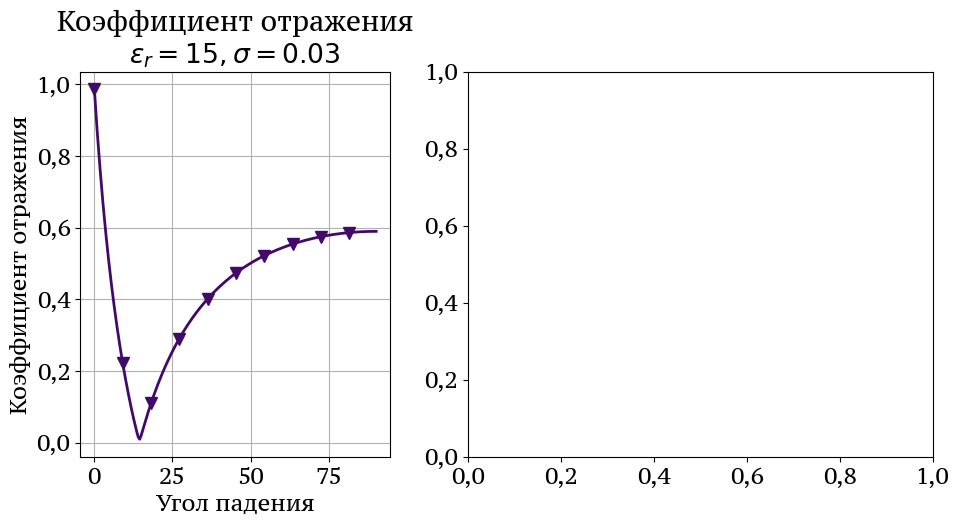

In [12]:
def plot_pathlosses(image_name: str = ""):
    """
    Нарисовать график затухания в канале для разных поляризаций антенн.
    
    Args:
        image_name (str): имя файла без расширения
    """
    ox = np.linspace(0.4, 30, 200)
    oa = np.linspace(0.1, 90, 200)
    
    y0 = [get_free_space_pathloss(x, 0, 0) for x in ox]
    yv = [get_pathloss(x, VERTICAL_POLARIZATION) for x in ox]

    rv = [get_reflection(channel.deg2rad(a), VERTICAL_POLARIZATION) for a in oa]

    fig, (ax0, ax1) = plt.subplots(figsize=(11, 5), nrows=1, ncols=2, 
                                   gridspec_kw={'width_ratios': [1, 1.5]})
    
    label_0 = "Канал без отражений"
    label_h = "Горизонтальная поляризация (метка)"
    label_v = "Вертикальная поляризация"
    label_c = "Круговая поляризация (считыватель)"
    
    c0 = get_color(0)
    cv = get_color(0.2)
    ch = get_color(0.5)
    cc = get_color(0.8)

    props_0 = {'color': c0, 'linewidth': 2, 'linestyle': '-.',
               'marker': 'X', 'markersize': 8, 'markevery': 20}
    props_v = {'color': cv, 'linewidth': 2, 'linestyle': '-',
               'marker': 'v', 'markersize': 8, 'markevery': 20}

    ax0.set_title("Коэффициент отражения\n" + 
                  r'$\epsilon_r = 15, \sigma = 0.03$')
    ax0.set_xlabel("Угол падения")
    ax0.set_ylabel("Коэффициент отражения")
    ax0.plot(oa, rv, label=label_v, **props_v)
    ax0.grid()

    # ax1.set_title("Затухание между считывателем\nи статичной меткой")
    # ax1.set_xlabel("Расстояние, м")
    # ax1.set_ylabel("Затухание, дБ")
    # ax1.plot(ox, y0, label=label_0, **props_0)
    # ax1.grid()
    # ax1.set_xlim((0, 30))


plot_pathlosses("ch2_pathloss")

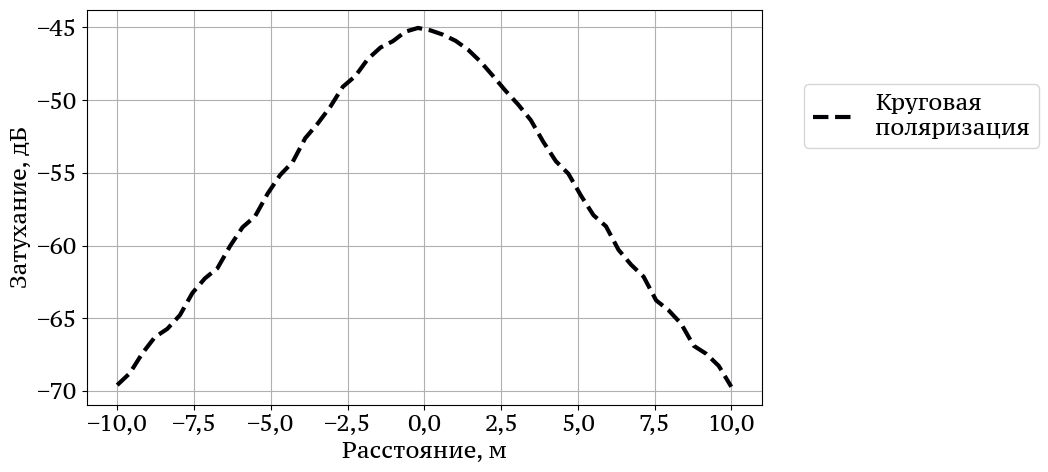

In [15]:
def plot_pathloss_with_doppler(
        image_name: str = "",
        v: float = 60,
        t: float = 1.0,
) -> None:
    """
    Нарисовать графики затуханий для круговой и горизонтальной поляризации
    для статичной метки, а также для горизонтальной поляризации антенны, 
    двигающейся с заданной скоростью для канала, существующего заданное время.
    
    Args:
        image_name (str): имя файла без расширения
        v (float): скорость метки, км/ч (по-умолчанию, 60)
        t (float): время с момента появления сигнала (по-умолчанию, 1)
    """
    ox = np.linspace(-10, 10, 50)
    
    yc = [get_pathloss(x, CIRCULAR_POLARIZATION) for x in ox]
    yh = [get_pathloss(x, HORIZONTAL_POLARIZATION) for x in ox]
    yv_3 = [get_pathloss(x, READER_POLARIZATION) for x in ox]
    yh60 = [get_pathloss(x, HORIZONTAL_POLARIZATION, v=channel.kmph2mps(v), t=t) 
            for x in ox]
    
    fig, ax = plt.subplots(figsize=(8, 5), nrows=1, ncols=1)
    
    ax.set_xlabel("Расстояние, м")
    ax.set_ylabel("Затухание, дБ")
    ax.plot(ox, yv_3, label="Круговая\nполяризация", 
            linestyle='--', linewidth=3, color=get_color(0))
    ax.grid()
    fig.legend(*ax.get_legend_handles_labels(), 
               loc='center right', bbox_to_anchor=(1.33, 0.74))
    plt.tight_layout()

    # savefig(image_name)

plot_pathloss_with_doppler("ch2_pathloss_3", v=60, t=1.0)

## Расчет мощностей сигналов

Рассчитаем мощности сигналов, которые отражает метка и принимает считыватель.

In [11]:
def get_tag_rx(x: float, v: float, t: float, 
               tx: float = READER_TX_POWER) -> float:
    """
    Вычислить мощность сигнала, принятого меткой.
    """
    path_loss = get_pathloss(x, READER_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

In [12]:
def get_tag_tx(rx: float):
    """
    Вычислить мощность сигнала, отраженного меткой.
    """
    return rx + TAG_BACKSCATTER_LOSS

In [13]:
def get_reader_rx(x: float, v: float, t: float, tx: float) -> float:
    """
    Вычислить мощность сигнала, принятого считывателем.
    """
    path_loss = get_pathloss(x, TAG_POLARIZATION, v, t)
    pol_loss = 0 if READER_POLARIZATION == TAG_POLARIZATION else -3.0
    gain = READER_GAIN + TAG_GAIN
    return tx + path_loss + pol_loss + gain + READER_CABLE_LOSS

Нам потребуется определять зоны, в которых метка получает сигнал, 
выше уровня ее чувствительности. Для этого определим функцию `find_high_zones()`, 
которая будет возвращать набор интервалов, внутри которых значение функции больше
граничного значения.

In [14]:
def find_zones(
        x: Sequence[float], 
        y: Sequence[float], 
        bound: float, 
        use_upper: bool = True
) -> Sequence[Tuple[float, float]]:
    """
    Найти интервалы на X, внутри которых значение Y выше или ниже лимита.
    
    Например, если use_upper = True, то есть ищем интервалы выше лимита, то
    возвращает набор интервалов `[(x0, x1), (x2, x3), ...]`, таких, что:
    - для x[2n] <= x <= x[2n+1]: y(x) >= B
    - для x[2n+1] <= x <= x[2n+2]: y(x) <= B
    
    Размерности x и y должны совпадать.
    
    Args:
        x (sequence of float): последовательность аргументов
        y (sequence of float): последовательность значений
        bound (float): граничное значение
        use_upper (bool): если True, то ищем области, в которых значение выше
    
    Returns:
        intervals (sequence of tuples): последовательность интервалов
    """
    # Специально делаем так, чтобы изначально is_upper не совпадало с тем,
    # что будет в первой точке:
    is_upper = False
    x_left: Optional[float] = None
    intervals = []
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        
        is_start_point = False
        is_end_point = False

        if (not is_upper or (use_upper and i == 0)) and yi >= bound:

            # Если выполняется равенство, нужно проверить, возрастает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi > bound or i == len(x)-1 or y[i+1] >= bound:
                is_upper = True
                if use_upper:
                    is_start_point = True
                else:
                    is_end_point = True
                            
        elif (is_upper or (not use_upper and i == 0)) and yi <= bound:

            # Если выполняется равенство, нужно проверить, убывает
            # ли функция в этой точке. Если нет - игнорируем.
            if yi < bound or i == len(y)-1 or y[i+1] <= bound:
                is_upper = False
                if use_upper:
                    is_end_point = True
                else:
                    is_start_point = True
        
        if is_start_point:
            x_left = xi
        if is_end_point:
            intervals.append((x_left, xi))
            x_left = None
    
    # После цикла проверяем, не надо ли закрыть интервал.
    if x_left is not None:
        intervals.append((x_left, x[-1]))
        
    return intervals

Zones where tag is off:  [(np.float64(-15.0), np.float64(-4.3939393939393945)), (np.float64(4.696969696969699), np.float64(15.0))]


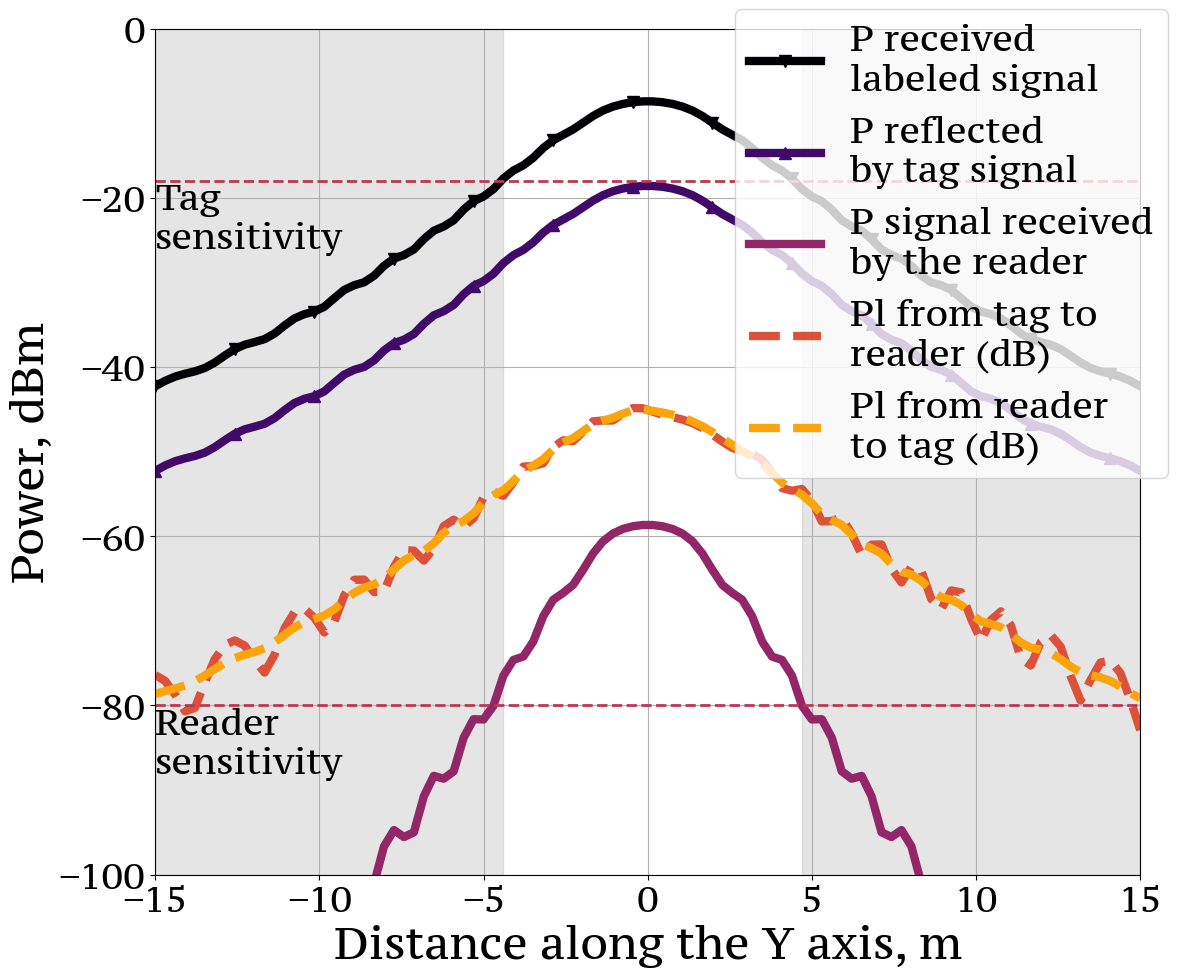

In [15]:
ox = np.linspace(-15, 15, 100)

tag_pl = [get_pathloss(x, TAG_POLARIZATION) for x in ox]
reader_pl = [get_pathloss(x, READER_POLARIZATION) for x in ox]
tag_rx = [get_tag_rx(x, 0, 0) for x in ox]
tag_tx = [get_tag_tx(rx) for rx in tag_rx]
reader_rx = [get_reader_rx(x, 0, 0, tx) for (x, tx) in zip(ox, tag_tx)]

y_min = -100
y_max = 0

fig, ax = plt.subplots(figsize=(12, 10), nrows=1, ncols=1)
    
ax.plot(ox, tag_rx, label="P received\nlabeled signal",
    linewidth=6, linestyle='-', marker='v', markevery=8, markersize=8,
    color=get_color(0))
ax.plot(ox, tag_tx, label="P reflected\nby tag signal",
    linewidth=6, linestyle='-', marker='^', markevery=8, markersize=8,
    color=get_color(0.2))
ax.plot(ox, reader_rx, label="P signal received\nby the reader",
    linewidth=6, color=get_color(0.4))
ax.plot(ox, tag_pl, label="Pl from tag to \nreader (dB)",
    linestyle='--', color=get_color(0.6), linewidth=6)
ax.plot(ox, reader_pl, label="Pl from reader\nto tag (dB)",
    linestyle='--', color=get_color(0.8), linewidth=6)

# Нарисуем линии чувствительности метки и считывателя
ax.hlines(y=TAG_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
      colors=get_color(0.5), linestyles='--', linewidths=2)
ax.hlines(y=READER_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
      colors=get_color(0.5), linestyles='--', linewidths=2)

ax.text(x=-15, y=TAG_SENSITIVITY-8, s="Tag\nsensitivity", 
    fontdict={'style': 'italic'}, fontsize=26)
ax.text(x=-15, y=READER_SENSITIVITY-8, fontsize=26,
    s="Reader\nsensitivity", 
    fontdict={'style': 'italic'})

# Выделим области, в которых метка выключена
tag_off_intervals = find_zones(ox, tag_rx, TAG_SENSITIVITY, use_upper=False)
print("Zones where tag is off: ", tag_off_intervals)
for interval in tag_off_intervals:
    ax.add_patch(patches.Rectangle(xy=(interval[0], y_min), 
        width=(interval[1] - interval[0]), 
        height=(y_max - y_min),
        fill=True, color='gray', alpha=0.2))    

ax.set_xlim((-15, ox[-1]))
ax.set_ylim((y_min, y_max))
ax.grid()
ax.set_xlabel("Distance along the Y axis, m", fontsize=32)
ax.set_ylabel("Power, dBm", fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=26)
    
handles, labels = ax.get_legend_handles_labels()
patch = patches.Patch(color='grey', alpha=0.5)
handles.append(patch)

labels.append("Area where\ntag is disabled")
    
fig.legend(bbox_to_anchor=(1, 1), fontsize=26)
# ax.set_title("Бюджет канала", fontsize=32)
    
plt.tight_layout()

Эффект Доплера сильно влияет на затухание и, как следствие, на мощность 
сигналов,  принятых меткой и считывателем. 

В следующем примере посмотрим, как меняется мощность при увеличении времени, 
прошеднего со включения считывателя. Метка будет двигаться со скоростью 
`60 км/ч`.

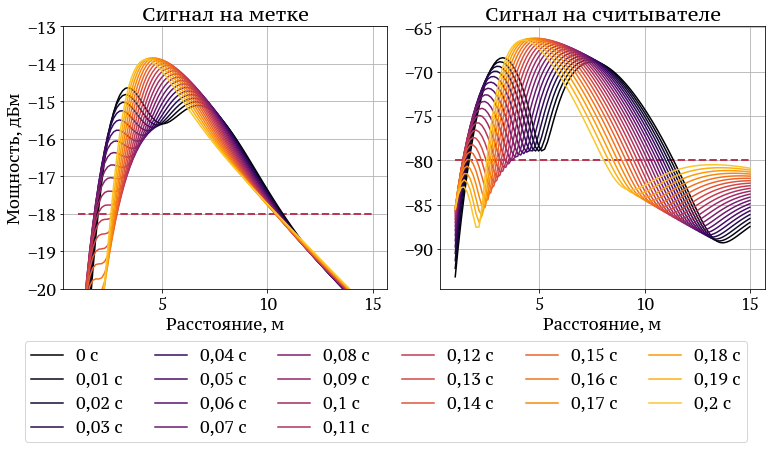

In [16]:
def plot_rx_power_doppler(image_name: str = "") -> None:
    """
    Нарисовать графики мощностей сигналов, принятых меткой и считывателем,
    с учетом эффекта Допера.
    
    Args:
        image_name (str): имя файла без расширения
    """
    ox = np.linspace(1, 15, 100)
    ts = np.linspace(0, 0.2, 21)
    v = kmph2mps(60)
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 5), nrows=1, ncols=2)
    
    for i, t in enumerate(ts):
        tag_rx = [get_tag_rx(x, v, t) for x in ox]
        tag_tx = [get_tag_tx(rx) for rx in tag_rx]
        rdr_rx = [get_reader_rx(x, v, t, tx) for (x, tx) in zip(ox, tag_tx)]
        
        color = get_color(i / (len(ts) * 1.1))
        
        ax0.plot(ox, tag_rx, label=f"{t:n} с", color=color)
        ax1.plot(ox, rdr_rx, color=color)
    
    ax0.set_ylabel("Мощность, дБм")
    for ax in (ax0, ax1):
        ax.grid()        
        ax.set_xlabel("Расстояние, м")
    
    ax0.set_ylim((-20, -13))
    
    ax0.set_title("Сигнал на метке")
    ax1.set_title("Сигнал на считывателе")

    ax0.hlines(y=TAG_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=2)
    ax1.hlines(y=READER_SENSITIVITY, xmin=ox[0], xmax=ox[-1], 
               colors=get_color(0.5), linestyles='--', linewidths=2)
    
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', 
               bbox_to_anchor=(0.5, -0.28), ncol=6) 

    plt.tight_layout()
    savefig(image_name)

plot_rx_power_doppler("ch2_rx_power_doppler")

## Расчет битовой ошибки

Рассчитаем битовую ошибку и исследуем, как она зависит от параметров 
канала и эффекта Доплера.

Для расчета BER нужно знать отношение "сигнал-шум" (SNR) $\gamma$. 
Для более точных результатов лучше вместо простого SNR использовать
величину, учитывающую количество принятой энергии на бит $\acute{\gamma}$:

$$
\acute{\gamma} = \frac{m E_s}{N_0} \cos^2 \phi_s,
$$
где:

- $m$ - число символов на бит в ответах метки (1, 2, 4 или 8);
- $E_s$ - энергия на один символ;
- $N_0/2$ - спектральная плотность шума;
- $\phi_s$ - разность фазы сигнала и фазы приема.

Отношение $E_s / N_0$ можно выразить через SNR $\gamma$, длительность символа
$T_s$ и ширину полосы $B$ как $E_s / N_0 = \gamma T_s B$. Величину $\phi_s$
можно оценить как $\frac{1}{\sqrt{\gamma T_{pr} B}}$, где $T_{pr}$ - длина
преамбулы. Подставляя в форумулу, получаем:

$$
\acute{\gamma} \approx m \gamma T_s B \cos^2 \frac{1}{\sqrt{\gamma T_{pr} B}}
$$


Самая простая формула для расчета BER - канал AWGN. В нем BER рассчитывается так:

$$
P_{er} = 2 Q(\acute{\gamma}) [1 - Q(\acute{\gamma})]
$$

Эта формула слишком оптимистична, поэтому для расчета BER будем использовать формулу, 
полученную усреднением BER для канала AWGN по распределению Рэлея:

$$
BER = \frac{1}{2} - 
      \frac{1}{\sqrt{1 + \frac{1}{\acute{\gamma}}}} + 
      \frac{2}{\pi} \frac{\arctan{\sqrt{1 + \frac{1}{\acute{\gamma}}}}}{1 + \frac{1}{\acute{\gamma}}}.
$$

In [17]:
NOISE = w2dbm(dbm2w(READER_NOISE) + dbm2w(THERMAL_NOISE))

def get_trcal(tari: float) -> float:
    """Вычислить TRcal от Tari."""
    rtcal = tari * RTCAL_MUL
    return rtcal * TRCAL_MUL


def get_blf(trcal: float, dr: float = DR) -> float:
    """Вычислить BLF."""
    return dr / trcal
    
    
def get_preamble(m: int, trcal: float, trext: bool = False,
                 dr: float = DR) -> float:
    """Вычислить длительность преамбулы ответа метки."""
    if m == 1:
        n_bits = 18 if trext else 6
    else:
        n_bits = 22 if trext else 10
    return n_bits / get_blf(trcal, dr)


def get_raw_snr(rx: float) -> float:
    """Вычислить отношение сигнал-шум."""
    return pyradise.signal2noise(rx_power=rx, noise_power=NOISE)


def get_snr(rx: float, m: int, trcal: float, trext: bool = False,
            dr: float = DR) -> float:
    """Вычислить SNR на бит с поправкой на синхронизацию."""
    snr = get_raw_snr(rx)
    preamble = get_preamble(m, trcal, trext, dr)
    sync = pyradise.sync_angle(snr=snr, preamble_duration=preamble)
    return pyradise.snr_extended(
        snr=snr, 
        sync_phi=sync, 
        miller=m, 
        symbol_duration=(1 / get_blf(trcal, dr))
    )

In [18]:
def get_awgn_ber(snr: float) -> float:
    """Вычислить BER для канала AWGN."""
    return pyradise.ber_over_awgn(snr=snr)


def get_ber(snr) -> float:
    """Вычислить BER для канала с распределенным по Рэлею SNR."""
    return pyradise.ber_over_rayleigh(snr=snr)

Рассчитаем BER для разных Tari, M и DR.

Чтобы немного упростить вывод, не будем рассматривать все возможные комбинации 
`Tari`, `M`, `DR`, а выделим шесть разных наборов:

- `Tari = 6.25, M = 1, DR = 64/3, TRext = False` (самый быстрый)
- `Tari = 6.25, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 64/3, TRext = False`
- `Tari = 12.5, M = 4, DR = 8, TRext = False`
- `Tari = 25.0, M = 4, DR = 8, TRext = True`
- `Tari = 25.0, M = 8, DR = 8, TRext = True` (самый медленный)

In [19]:
SERIES = [
    [6.25, gen2.TagEncoding.FM0, gen2.DR.DR_643],
    [6.25, gen2.TagEncoding.FM0, gen2.DR.DR_8],
    [6.25, gen2.TagEncoding.M4, gen2.DR.DR_643],
    [12.5, gen2.TagEncoding.M4, gen2.DR.DR_643],
    [12.5, gen2.TagEncoding.M4, gen2.DR.DR_8],
    [25.0, gen2.TagEncoding.M4, gen2.DR.DR_8],
    [25.0, gen2.TagEncoding.M8, gen2.DR.DR_8]
]
SERIES_SIZE = len(SERIES)
SERIES_MARKERS = ["o", "v", "^", "X", "D", "*", "s"]
SERIES_COLORS = [get_color(i / SERIES_SIZE * 0.8) for i in range(SERIES_SIZE)]

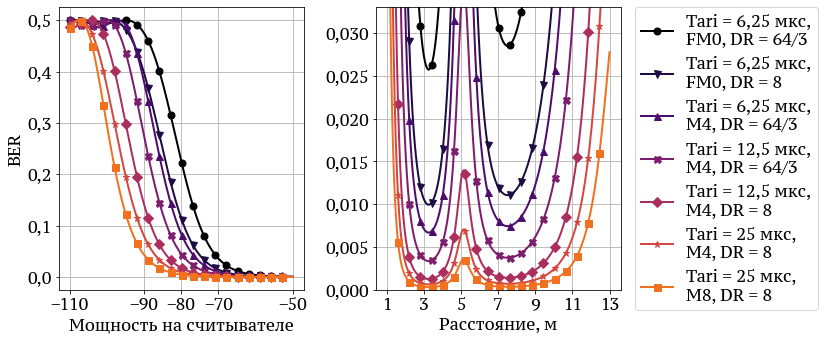

In [20]:
def plot_ber(image_name: str = "") -> None:
    """
    Нарисовать графики зависимостей BER от SNR и от расстояния между 
    считывателем и меткой.
    
    Args:
        image_name (str): имя файла без расширения
    """
    fig, axes = plt.subplots(figsize=(9, 5), nrows=1, ncols=2)
    ax0, ax1 = axes

    ox = np.linspace(1, 13, 200)
    basic_rx = np.linspace(-110, -50, 200)
        
    tag_rx = [get_tag_rx(x, 0, 0) for x in ox]
    tag_tx = [get_tag_tx(rx) for rx in tag_rx]
    rdr_rx = [get_reader_rx(x, 0, 0, tx) for (x, tx) in zip(ox, tag_tx)]
    
    for i, (tari_us, m, dr) in enumerate(SERIES):
        tari = tari_us * 1e-6
        trcal = get_trcal(tari)
        m_ = m.value
        
        rdr_snr = [get_snr(rx, m_, trcal, False, dr.ratio) for rx in rdr_rx]
        rdr_ber = [get_ber(snr) for snr in rdr_snr]
        
        basic_snr = [get_snr(rx, m_, trcal, False, dr.ratio) for rx in basic_rx]
        basic_ber = [get_ber(snr) for snr in basic_snr]
        
        props = {
            'linewidth': 2, 
            'marker': SERIES_MARKERS[i], 
            'color': SERIES_COLORS[i],
            'markevery': 10, 
            'markersize': 7,
            'label': (f"Tari = {tari_us:n} мкс,\n"
                      f"{m.name}, DR = {str_dr(dr)}")
        }
        ax0.plot(basic_rx, basic_ber, **props)
        ax1.plot(ox, rdr_ber, **props)        
    
    for ax in axes:
        ax.grid()
    
    ax0.set_ylabel("BER")
    ax0.set_xlabel("Мощность на считывателе")
    ax1.set_xlabel("Расстояние, м")
    ax1.set_ylim((0, 0.033))
    ax0.set_xticks((-110, -90, -80, -70, -50))
    ax1.set_xticks((1, 3, 5, 7, 9, 11, 13))
    
    fig.legend(*ax0.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.29, 0.533), ncol=1)

    plt.tight_layout()
    savefig(image_name)

plot_ber("ch2_ber")

Теперь рассчитаем BER с учетом эффекта Доплера.

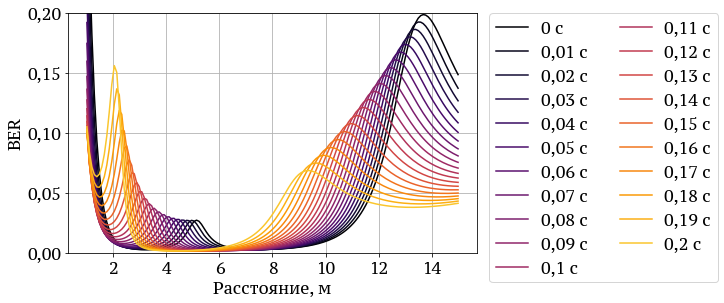

In [21]:
def plot_ber_doppler(
        image_name: str = "", 
        m: int = 2, 
        tari_us: float = 12.5
) -> None:
    """
    Нарисовать график BER от расстояния по земле с учетом эффекта Доплера.
    
    Args:
        image_name (str): имя файла без расширения
        m (int): число символов на бит в ответе метки (1, 2, 4, 8)
        tari_us (float): величина Tari в микросекундах (по-умолчанию, 12.5)
    """
    ox = np.linspace(1, 15, 150)
    ts = np.linspace(0, 0.2, 21)
    v = kmph2mps(60)
    fig, ax = plt.subplots(figsize=(7, 4.5), nrows=1, ncols=1)
    
    tari = tari_us * 1e-6
    trcal = get_trcal(tari)
    
    for i, t in enumerate(ts):
        tag_rx = [get_tag_rx(x, v, t) for x in ox]
        tag_tx = [get_tag_tx(rx) for rx in tag_rx]
        rdr_rx = [get_reader_rx(x, v, t, tx) for (x, tx) in zip(ox, tag_tx)]
        
        rdr_snr = [get_snr(rx, m, trcal) for rx in rdr_rx]
        ber = [get_ber(snr) for snr in rdr_snr]
        
        color = get_color(i / (len(ts) * 1.1))
        ax.plot(ox, ber, label=f"{t:n} с", color=color)
    
    ax.grid()
    ax.set_ylabel("BER")
    ax.set_xlabel("Расстояние, м")
    ax.set_ylim((0, 0.2))
    
    # ax0.set_ylim((-20, -13))
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.46, 0.51), ncol=2) 
        
    plt.tight_layout()
    savefig(image_name)

plot_ber_doppler("ch2_ber_doppler")